In [1]:
# authorize google account to use bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# authorize drive to pull model
from google.colab import drive
drive.mount('/content/drive')

# pull data for repo from bigquery
project_id = 'uic-capstone-int'
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

Authenticated
Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Cloudbakers/Assets/')

# Repo Health predictor
Score Range: 1-10

1=> Highly Dormant

10=> Highly Active

Data Extraction Successful for repoID: 133959957


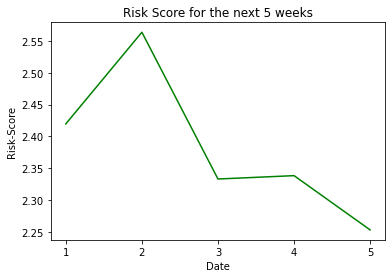

In [126]:
#@title Default title text
Repo_id = 133959957 #@param {type:"integer"}

import json
import requests
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import config
from termcolor import colored
import time
import seaborn as sns
import os
import matplotlib.pyplot as plt
import random
from datetime import datetime
from sklearn.metrics import r2_score
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


id = [Repo_id]

github_api = "https://api.github.com"
gh_session = requests.Session()
gh_session.auth = (config.GITHUB_USERNAME, config.GITHUB_TOKEN)


def commits_of_repo_github(repo, owner, api):
    commits = []
    next = True
    i = 1
    while next == True:
        url = api + '/repos/{}/{}/commits?page={}&per_page=100'.format(owner, repo, i)
        commit_pg = gh_session.get(url = url)
        commit_pg_list = [dict(item, **{'repo_name':'{}'.format(repo)}) for item in commit_pg.json()]    
        commit_pg_list = [dict(item, **{'owner':'{}'.format(owner)}) for item in commit_pg_list]
        commits = commits + commit_pg_list
        if 'Link' in commit_pg.headers:
            if 'rel="next"' not in commit_pg.headers['Link']:
                next = False
        i = i + 1
    return commits



def create_commits_df(repo, owner, api):
    commits_list = commits_of_repo_github(repo, owner, api)
    return json_normalize(commits_list)


def RESTdb(repo_name_list):

      repo_name_df = pd.DataFrame(repo_name_list,columns=['owner_repo'])
      repo_name_df[['owner','repo']] = repo_name_df.owner_repo.str.split("/",n=1,expand=True)
      get_commit = pd.DataFrame()
      for k in range(0,len(repo_name_df)):
        
        
        try:
            
            REST_df = create_commits_df(repo_name_df.iloc[k].repo, repo_name_df.iloc[k].owner, github_api)
            REST_df = REST_df[['sha','commit.committer.date','commit.committer.email']]
            REST_df['commit.committer.date'] = pd.to_datetime(REST_df['commit.committer.date'])
            REST_df['commit.committer.date'] = REST_df['commit.committer.date'].dt.date
            REST_df.rename({'commit.committer.date':'committed_date','commit.committer.email':'email', 'sha':'commit'}, axis=1, inplace=True)
            get_commit = get_commit.append(REST_df, ignore_index=True)
            
        except:
            continue
      return get_commit



df = pd.DataFrame()

sql='''

SELECT FORMAT_DATETIME("%Y-%m-%d", DATETIME(date)) AS year_month, repoID, repo_name, type, count (*) ct
FROM
(

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2015
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2016
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2017
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2018
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2019
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)
)
GROUP BY 1,2,3,4
ORDER BY 1;'''


job_configuration = bigquery.QueryJobConfig(
    query_parameters=[bigquery.ArrayQueryParameter("ids", "INT64", id),]
)


dfx = client.query(
    sql,
    job_config=job_configuration
    ).to_dataframe()


#-------------------------Commit_author_count event creation-------------------

job_configuration = bigquery.QueryJobConfig(
    query_parameters=[bigquery.ArrayQueryParameter("ids", "INT64", id),]
)

sql = '''
SELECT FORMAT_DATETIME("%Y-%m-%d", DATETIME(date)) AS year_month, repoID, repo_name, COUNT( DISTINCT a_id) AS ct
FROM (
    
SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2015
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2016
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2017
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2018
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2019
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

)
GROUP BY 1,2,3
ORDER BY 1;'''

Cac = client.query(
    sql,
    job_config=job_configuration
    ).to_dataframe()
Cac['type'] = 'Commit_author_count'


#Union
dfx = pd.concat([dfx, Cac])


#-------------------------Issue_author_count event creation-------------------

job_configuration = bigquery.QueryJobConfig(
    query_parameters=[bigquery.ArrayQueryParameter("ids", "INT64", id),]
)

sql = '''
SELECT FORMAT_DATETIME("%Y-%m-%d", DATETIME(date)) AS year_month, repoID, repo_name, COUNT( DISTINCT a_id) AS ct
FROM (
    
SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2015
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2016
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2017
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2018
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2019
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

)
GROUP BY 1,2,3
ORDER BY 1;'''

Iac = client.query(
    sql,
    job_config=job_configuration
    ).to_dataframe()
Iac['type'] = 'Issue_author_count'


#Union
dfx = pd.concat([dfx, Iac])


for i in range(0,len(id)):

  dfPushes = dfx.loc[(dfx['type'] == 'PushEvent') & (dfx['repoID']==id[i])]
  dfPushes.rename(columns={'ct':'number_of_pushes'}, inplace=True)
  repo_name_list = dfPushes['repo_name'].unique().tolist()

  dfForks = dfx.loc[(dfx['type'] == 'ForkEvent') & (dfx['repoID']==id[i])]
  dfForks.rename(columns={'ct':'number_of_forks'}, inplace=True)
  
  dfPulls = dfx.loc[(dfx['type'] == 'PullRequestEvent') & (dfx['repoID']==id[i])]
  dfPulls.rename(columns={'ct':'number_of_pulls'}, inplace=True)
  
  dfBookmarks = dfx.loc[(dfx['type'] == 'WatchEvent') & (dfx['repoID']==id[i])]
  dfBookmarks.rename(columns={'ct':'number_of_bookmarks'}, inplace=True)


  dfIssues = dfx.loc[(dfx['type'] == 'IssuesEvent') & (dfx['repoID']==id[i])]
  dfIssues.rename(columns={'ct':'number_of_issues'}, inplace=True)


  dfIssuecomment = dfx.loc[(dfx['type'] == 'IssueCommentEvent') & (dfx['repoID']==id[i])]
  dfIssuecomment.rename(columns={'ct':'issue_comment_count'}, inplace=True)


  dfIssue_author_count = dfx.loc[(dfx['type'] == 'Issue_author_count') & (dfx['repoID']==id[i])]
  dfIssue_author_count.rename(columns={'ct':'issue_author_count'}, inplace=True)


  dfCommitcomment = dfx.loc[(dfx['type'] == 'CommitComentEvent') & (dfx['repoID']==id[i])]
  dfCommitcomment.rename(columns={'ct':'commit_comment_count'}, inplace=True)

  dfCommit_author_count = dfx.loc[(dfx['type'] == 'Commit_author_count') & (dfx['repoID']==id[i])]
  dfCommit_author_count.rename(columns={'ct':'commit_author_count'}, inplace=True)
  
  
  merge1 = pd.merge(dfPushes,dfForks,how='outer', on='year_month')
  merge2 = pd.merge(merge1, dfPulls, how='outer', on='year_month')
  merge3 = pd.merge(merge2, dfBookmarks, how='outer', on='year_month')
  merge4 = pd.merge(merge3, dfIssuecomment, how='outer', on='year_month')
  merge5 = pd.merge(merge4,dfCommitcomment,how='outer',on='year_month')
  merge6 = pd.merge(merge5, dfIssues, how='outer',on='year_month')
  merge7 = pd.merge(merge6, dfIssue_author_count, how='outer',on='year_month')
  merge8 = pd.merge(merge7, dfCommit_author_count, how='outer',on='year_month')
  merge8.drop(['repoID_x','repoID_y','type_x','type_y','type', 'repo_name_x','repo_name_y', 'repo_name'], axis=1, inplace=True)
  merge8['repoID']=id[i]
  merge8.sort_values(by='year_month',ascending=True,inplace=True)
  
  merge8['year_month']=pd.to_datetime(merge6['year_month'])
  merge8.rename({'year_month': 'datetime'}, axis=1, inplace=True)
  merge8.index=merge8['datetime']
  merge8.drop('datetime',axis=1,inplace=True)

  WeeklyTS = pd.DataFrame()
  WeeklyTS = merge8.resample('W').sum()
  WeeklyTS.reset_index(level=0, inplace=True)

  # repo_name_tuple = tuple(repo_name_list)


  dfCommits = RESTdb(repo_name_list)
  
  if dfCommits.empty:
    print(colored('Data Extraction Failed No commits data for repoID: %d'%id[i], color='red'))
    continue

  else:
    print(colored('Data Extraction Successful for repoID: %d' %id[i], color='green'))


  dfCommits['committed_date']=pd.to_datetime(dfCommits['committed_date'])
  dfCommits.index=dfCommits['committed_date']
  dfCommits.drop('committed_date',axis=1,inplace=True)
  Weekly_commit_TS = pd.DataFrame()
  Weekly_commit_TS = dfCommits.resample('W').agg({'commit': 'count', 'email': 'nunique'})
  Weekly_commit_TS.rename(columns={"commit":"commit_count","email":"unique_committer_count"}, inplace=True)
  Weekly_commit_TS.reset_index(level=0, inplace=True)
  Weekly_commit_TS.rename(columns={'committed_date':'datetime'}, inplace=True)
  WeeklyTS = pd.merge(WeeklyTS,Weekly_commit_TS,how='outer', on='datetime')
  WeeklyTS.drop('repoID', axis=1, inplace=True)
  WeeklyTS.fillna(0, inplace=True)
  WeeklyTS['Total_count'] = WeeklyTS.drop('datetime',axis=1).sum(axis=1)
  

  # Setting Threshold in terms of percentage of drop
  Threshold = 0.1
  for j in range(5,len(WeeklyTS)):
    Avg = WeeklyTS['Total_count'].iloc[j-5:j,].mean()
    diff = WeeklyTS['Total_count'].iloc[j] - WeeklyTS['Total_count'].iloc[j-1]
    if diff>=0:
      WeeklyTS.loc[j,'Status'] = 1
    else:
      if abs(diff)/Avg < Threshold:
        WeeklyTS.loc[j,'Status'] = 1
      else:
        WeeklyTS.loc[j,'Status'] = 0


  WeeklyTS.index = WeeklyTS['datetime']
  WeeklyTS.drop('datetime', axis=1, inplace=True)
  WeeklyTS.insert(0, 'year', WeeklyTS.index.year)
  WeeklyTS.insert(1, 'month', WeeklyTS.index.month)
  WeeklyTS.insert(2, 'day', WeeklyTS.index.day)
  WeeklyTS.reset_index(level=0, inplace=True)
  WeeklyTS['repoID']=id[i]


  df=df.append(WeeklyTS, ignore_index=True)


ds=df
ds = ds[ds['Total_count'].notna()]
# ds.drop('Unnamed: 0', axis=1, inplace=True)


attributes = ['commit_count','number_of_bookmarks','number_of_pushes','number_of_forks','number_of_pulls','unique_committer_count','issue_comment_count','issue_author_count','number_of_issues','commit_comment_count','commit_author_count']
weights = [0.265982,0.151779,0.111914,0.098709,0.094123,0.090812,0.071414,0.059612,0.040631,0.007819,0.007206]


ds.drop(['Total_count', 'Status'], axis=1, inplace=True)
ds['Risk_Score'] = ds[attributes].mul(weights).sum(1)
WeeklyTS = ds[['year','month','day','repoID','Risk_Score']]
WeeklyTS = WeeklyTS[WeeklyTS.year>2014]


now=datetime.now()
today = now.strftime("%Y-%m-%d")



# WeeklyTS = pd.read_csv('BiggerDS-Part1.csv')
WeeklyTS['year'] = WeeklyTS['year'].astype(int)
WeeklyTS['month'] = WeeklyTS['month'].astype(int)
WeeklyTS['day'] = WeeklyTS['day'].astype(int)
# WeeklyTS.drop('Unnamed: 0', axis=1, inplace=True)
# WeeklyTS = WeeklyTS[WeeklyTS.year > 2014]
WeeklyTS['dateInt']=WeeklyTS['year'].astype(str) + WeeklyTS['month'].astype(str).str.zfill(2)+ WeeklyTS['day'].astype(str).str.zfill(2)
WeeklyTS['Date'] = pd.to_datetime(WeeklyTS['dateInt'], format='%Y%m%d')
WeeklyTS.drop(['year','month','day','dateInt'], axis=1, inplace=True)
x =pd.DataFrame(WeeklyTS.groupby('repoID').count())
x = x[x.Risk_Score>90].index.astype(int).tolist()
WeeklyTS = WeeklyTS[WeeklyTS.repoID.isin(x)]


WeeklyTS['Date'] = WeeklyTS['Date'].dt.strftime('%Y-%m-%d')
WeeklyTS.reset_index(level=0, inplace=True)
WeeklyTS.drop('index', axis=1, inplace=True)



#Imputation function returning results with maximum R2
def imputation(WeeklyTS,i):

    y = WeeklyTS[WeeklyTS.repoID==i].sort_values('Date')
    y['Date']= pd.to_datetime(y['Date'])
    y.index=y['Date']
    y.drop('Date',axis=1,inplace=True)
    idx = pd.date_range('2015-01-01', today, freq='W-SUN')
    y.index = pd.DatetimeIndex(y.index)
    y = y.reindex(idx, fill_value=0)

    y['Risk_Score']=y['Risk_Score'].replace({0:np.nan})
    y.drop('repoID', axis=1, inplace=True)
    y = y.assign(InterpolateLinear=y.Risk_Score.interpolate(method='linear', limit_direction='both'))
    y = y.assign(InterpolateTime=y.Risk_Score.interpolate(method='time', limit_direction='both'))
    y = y.assign(InterpolateQuadratic=y.Risk_Score.interpolate(method='quadratic',limit_direction='both'))
    y = y.assign(InterpolateCubic=y.Risk_Score.interpolate(method='cubic',limit_direction='both'))
    y = y.assign(InterpolateSLinear=y.Risk_Score.interpolate(method='slinear',limit_direction='both'))
    y = y.assign(InterpolateAkima=y.Risk_Score.interpolate(method='akima',limit_direction='both'))
    y = y.assign(InterpolatePoly5=y.Risk_Score.interpolate(method='polynomial', order=5, limit_direction='both')) 
    y = y.assign(InterpolatePoly7=y.Risk_Score.interpolate(method='polynomial', order=7,limit_direction='both'))
    y = y.assign(InterpolateSpline3=y.Risk_Score.interpolate(method='spline', order=3, limit_direction='both'))
    y = y.assign(InterpolateSpline4=y.Risk_Score.interpolate(method='spline', order=4,limit_direction='both'))
    y = y.assign(InterpolateSpline5=y.Risk_Score.interpolate(method='spline', order=5,limit_direction='both'))
    y = y.assign(FillMean=y.Risk_Score.fillna(y.Risk_Score.mean())) # imputing using the mean
    y = y.assign(FillMedian=y.Risk_Score.fillna(y.Risk_Score.median())) # imputing using the median
    y = y.assign(RollingMean=y.Risk_Score.fillna(y.Risk_Score.rolling(24,min_periods=1,).mean())) # imputing using the rolling mean
    y = y.assign(RollingMedian=y.Risk_Score.fillna(y.Risk_Score.rolling(24,min_periods=1,).median()))# imputing using the rolling median

    y.fillna(0, inplace=True)

    results = [(method, r2_score(y['Risk_Score'].fillna(0), y[method])) for method in list(y)[3:]]
    results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
    result_df = results_df.sort_values(by='R_squared', ascending=False)
    column_name =result_df.iloc[0].Method
    y=y[[column_name]]
    y.reset_index(level=0, inplace=True)
    y['Date'] = y['index'].dt.strftime('%Y-%m-%d')
    y.drop('index',axis=1, inplace=True)
    y.rename(columns={column_name:'Risk_Score'},inplace=True)
    y['repoID']=i
    return y



repo_ids = WeeklyTS['repoID'].unique().tolist()

for i in range(0,len(repo_ids)):
   
      impute = imputation(WeeklyTS,repo_ids[i])
WeeklyTS = impute




#Scalimg between 1-10
ScaledDS = pd.DataFrame()
for i in range(0,len(repo_ids)):
   TransformDS = WeeklyTS[WeeklyTS.repoID==repo_ids[i]]
   max = TransformDS['Risk_Score'].max()
   min = TransformDS['Risk_Score'].min()
   div = max - min
   scaled_risk_score = ((TransformDS.Risk_Score-min)/div)*10
   scaled_risk_score = pd.DataFrame(scaled_risk_score)
   scaled_risk_score.rename(columns={'Risk_Score':'Scaled_Risk_Score'}, inplace=True)
   scaledDS = pd.concat([TransformDS,scaled_risk_score],axis=1)
   ScaledDS = ScaledDS.append(scaledDS)
WeeklyTS = ScaledDS
WeeklyTS.drop('Risk_Score', axis=1, inplace=True)
WeeklyTS.rename(columns={'Scaled_Risk_Score':'Risk_Score'}, inplace=True)
WeeklyTS.reset_index(level=0,inplace=True)
WeeklyTS.drop('index',axis=1, inplace=True)


#Converting to numpy array
Sub_WeeklyTS = WeeklyTS.sort_values(by=['Date'])
Sub_WeeklyTS.index=Sub_WeeklyTS['Date']
Sub_WeeklyTS.drop('Date',axis=1,inplace=True)
Sub_WeeklyTS.drop(['repoID'], axis=1, inplace=True)
Risk_Score = Sub_WeeklyTS.Risk_Score.to_numpy()





def preprocessing(series):
    '''
    MinMax Scaling of the raw time series
    Args:
        series: the raw time series
    Returns:
        scaled_series and scaler object
    '''
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series.reshape(-1,1))
    scaled_series = scaled.reshape((len(series),))
    
    return scaled_series, scaler

def inverse_transform(series,scaler):
    '''
    Inverse transform of scales series
    Args:
        series: scaled series
        scaler: scaler object
    Returns:
        unscaled series
    '''
    return scaler.inverse_transform(series.reshape(-1,1))


#Prediction function
def predict_ahead(model,X_test,n_ahead):
    '''
    Makes predictions based on the last available sequence
    
    Args:
        model: keras sequential model
        X_test: the last available sequence
        n_ahead: number of predictions to make 
        
    Returns:
        predictions: numpy array containing the predicted values
        
    '''    
    predictions = np.zeros(n_ahead)
    predictions[0] = model.predict(X_test,batch_size = 1)
    
    if n_ahead > 1:
        for i in range(1,n_ahead):
            x_new = np.append(X_test[0][1:],predictions[i-1])
            X_test = x_new.reshape(1,x_new.shape[0],1)
            predictions[i] = model.predict(X_test,batch_size = 1)
    return predictions



#Last 10 scores to predict
Risk_Score=np.trim_zeros(Risk_Score)
scaled_series, scaler =preprocessing(Risk_Score)
Risk_Score_last10 = scaled_series[-10:]


#Load model
model_ = keras.models.load_model('Transfer_learning_model_BiggerDS_Imputation')

#Reshape input array
input_size=10
X_test = Risk_Score_last10.reshape(1,input_size,1)


#Predict next 5 scores
predictions=predict_ahead(model_,X_test,5)


Final_Score=inverse_transform(predictions, scaler)
Final_Score=Final_Score.reshape(5)
Final_Score[Final_Score<0] = 0

# data to be plotted 
x = np.arange(start=1, stop=6, step=1)

fig = plt.figure()
fig.patch.set_facecolor('white') 
plt.title("Risk Score for the next 5 weeks")  
plt.xlabel("Date")  
plt.ylabel("Risk-Score")
plt.xticks(np.arange(0, 6, 1))
plt.plot(x, Final_Score, color ="green")  
plt.show()